In [1]:

import numpy as np
import json
from pprint import pprint

from collections import defaultdict
import operator

import matplotlib.pyplot as plt; plt.rcdefaults()


import seaborn as sns

import sys
sys.path.append('/projects2/refer360test/src')
sys.path.append('/projects2/lxmert/src/')

import os
from tqdm import tqdm
from utils import rad2degree
from panoramic_camera import PanoramicCamera as camera

from utils import DIRECTIONS, CAT2LOC
from fov_pretraining import load_fovpretraining_splits, get_object_dictionaries

In [2]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    #IPython.display.display(i)

In [ ]:
splits = ['train']
#objects = 'table chair door television car table,chair,door,television,car'.split(' ')
objects = 'table,chair,door,television,car'.split(' ')

data = {}
for o in objects:
  for d in DIRECTIONS:
    obj_dict_file = '../../data/vg_object_dictionaries.{}.json'.format(o)
    data_root = '../../data/fov_pretraining_{}'.format(o)
    vg2idx, idx2vg, obj_classes = get_object_dictionaries(obj_dict_file)
    
    fovs, fov_files, regions, refexps,  obj_lists, \
    obj_queries, obj_directions, labels, pano_metas, _ = load_fovpretraining_splits(splits,d,
                                                                                 data_root =data_root,
                                                                                 obj_classes=obj_classes)
    data[o + '|||' + d] = (labels,obj_classes)

In [ ]:
nrow = len(DIRECTIONS)
ncols = 1

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(16,32))
fig.subplots_adjust(hspace = 0.1 ) 

FONTSIZE=24

ii = -1

object_list='table,chair,door,television,car'
for kk,d in enumerate(DIRECTIONS):

  c = object_list + '|||'+ d
  directions = DIRECTIONS[d]
  

  
  datum = []
  object_names = []
  labels = data[c][0]
  obj_classes = data[c][1]
  
  for d in directions:
    dlist = []
    for o_id in sorted(labels.keys()):
      dlist.append(labels[o_id][d])
    datum.append(dlist)
  datum = np.array(datum)
  
  for column in range(datum.shape[1]):
    columnsum = sum(datum[:,column])
    for row in range(datum.shape[0]):
      datum[row,column] /= columnsum
  object_names = [obj_classes[o_id] for o_id in sorted(labels.keys())]
      
  axs[kk].imshow(datum)
  #axs[kk].set_title('{}'.format(c), fontsize=FONTSIZE)
  
  axs[kk].set_xticks(np.arange(len(object_names)))
  axs[kk].set_yticks(np.arange(len(directions)))
  # ... and label them with the respective list entries
  axs[kk].set_xticklabels(object_names,
                             fontsize=FONTSIZE)
  axs[kk].set_yticklabels(directions,
                             fontsize=FONTSIZE)

  # Rotate the tick labels and set their alignment.
  plt.setp(axs[kk].get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  
  for i in range(len(directions)):
      for j in range(len(object_names)):
          text = axs[kk].text(j, i, '{:2.2f}'.format(datum[i, j]),
                              ha="center",
                              va="center",
                              color="w",
                             fontsize=FONTSIZE)
  
  
plt.rc('xtick',labelsize=FONTSIZE)
plt.rc('ytick',labelsize=FONTSIZE)
fig.tight_layout()

plt.show()


In [3]:
data_path='../../py_bottom_up_attention/demo/data/genome/1600-400-20'
vg_classes = []

with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
  for object in f.readlines():
    vg_classes.append(object.split(',')[0].lower().strip())

In [4]:
image_list = [line.strip()
              for line in open('../../data/imagelist.txt')]  
image_root = '../../data/refer360images'
graph_root = '../../data/graph_data/'

topk = 50
obj_list = [line.strip().split(' ')[2]
              for line in open('../object_list.txt')][:topk]

#pbar = tqdm(image_list)
pbar = image_list

node_list = []


pano_stats = {}
pano_stats['location'] = {}
pano_stats['category'] = {}
      
#vg2idx, idx2vg, obj_classes = get_objects_classes('../../data/vg_object_dictionaries.table,chair,door,television,car.json',
#                                                     data_path='../../py_bottom_up_attention/demo/data/genome/1600-400-20')

#obj_set = set('table,chair,door,television,car,bus,tree'.split(','))
#obj_list = list(obj_set)
obj_set = set(obj_list)
for fname in pbar:
  image_path = os.path.join(image_root, fname)
  pano = fname.split('/')[-1].split('.')[0]

  node_path = os.path.join(
      graph_root, '{}.npy'.format(pano))

  nodes = np.load(node_path,
                  allow_pickle=True)[()]
  node_list.append(nodes)
  
  pano_category = fname.split('/')[-2]
  pano_id = "_".join(fname.split(
        '/')[-1].split('.')[0].split('_')[:2])
  pano_loc = CAT2LOC[pano_category]
  
  for node in nodes:
    x = nodes[node]['x']
    y = nodes[node]['y']
    vg_obj_id = nodes[node]['obj_id']
    
    obj = vg_classes[vg_obj_id]
    if obj not in obj_set:
      continue

    if obj not in pano_stats['location']:
      pano_stats['location'][obj] = defaultdict(int)
      pano_stats['category'][obj] = defaultdict(int)

    pano_stats['category'][obj][pano_category] += 1.0
    pano_stats['location'][obj][pano_loc] += 1.0
          
#pbar.close()

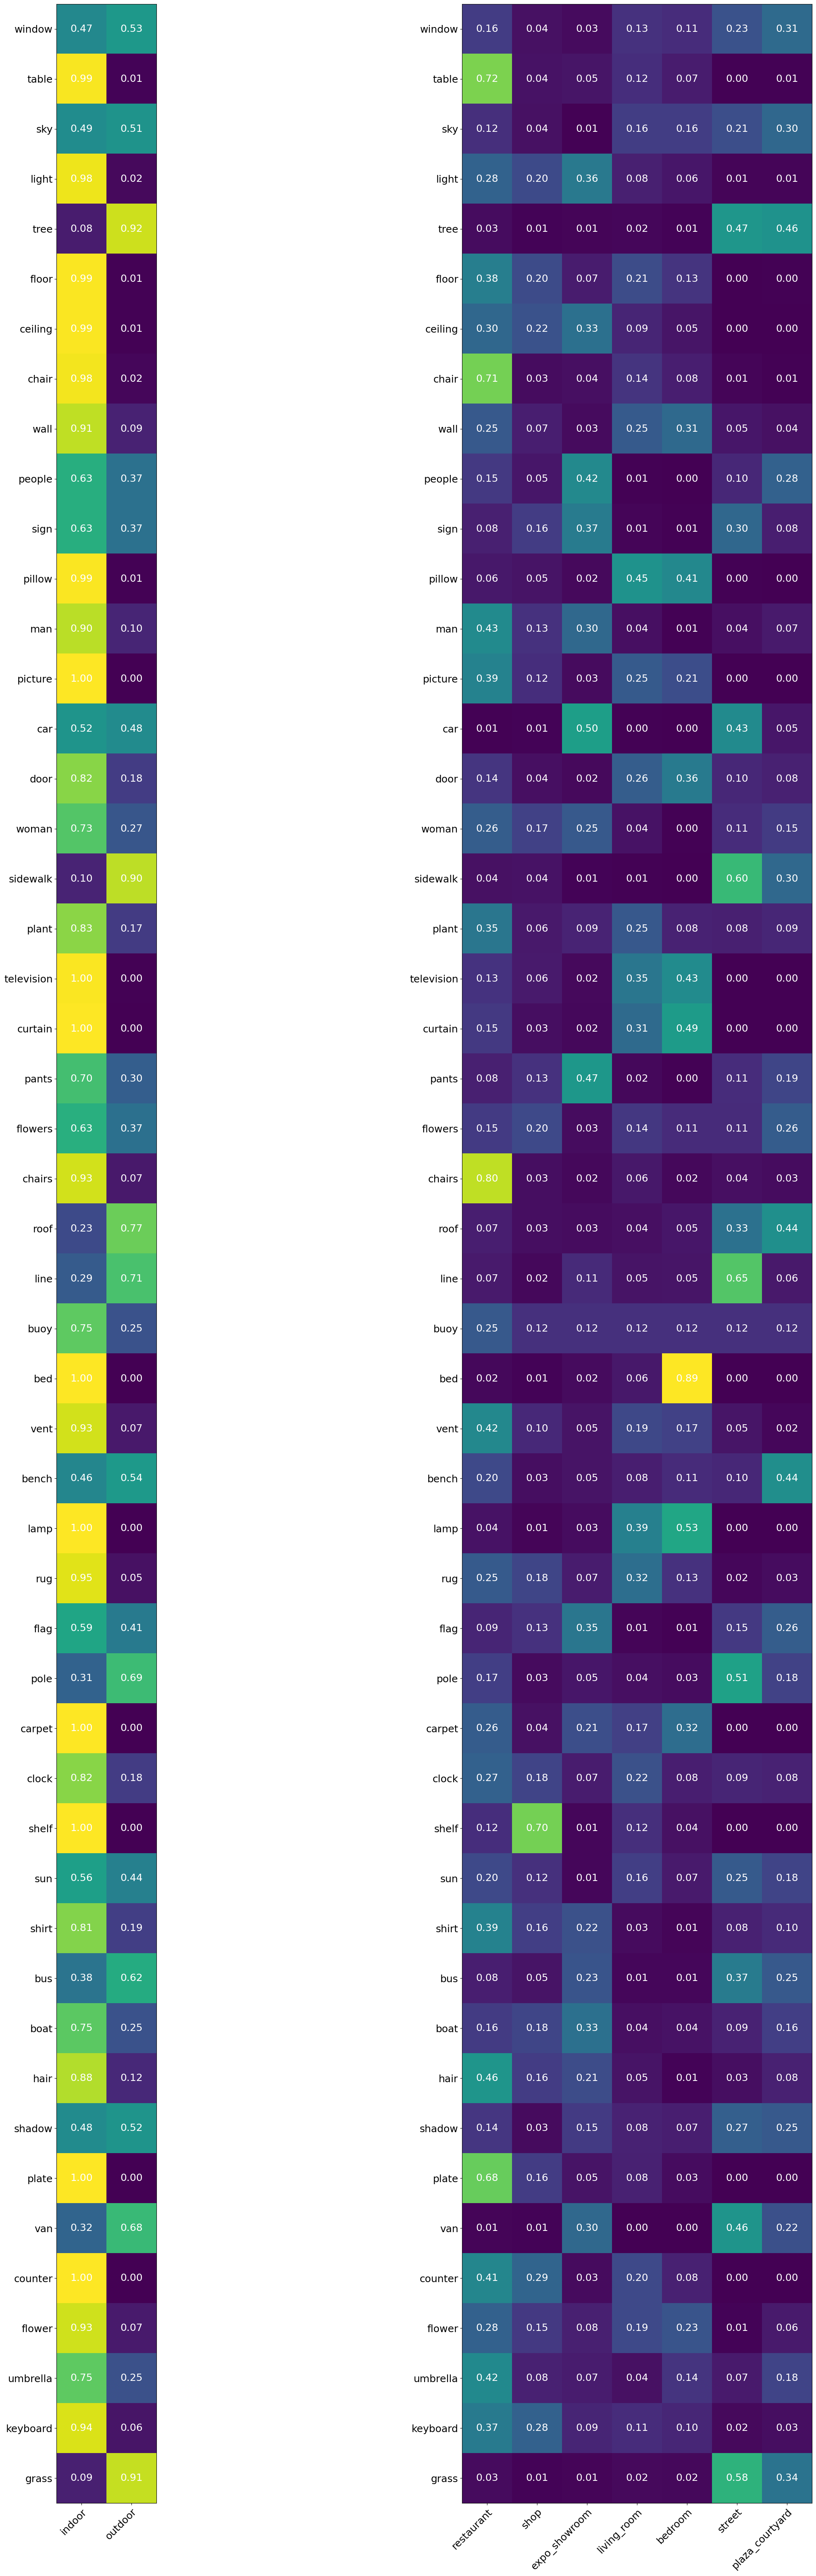

In [5]:
PANO={'location' : ['indoor','outdoor'],
     'category': CAT2LOC.keys()}

ncols = len(PANO)
nrow  = 1


fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(32,64))
fig.subplots_adjust(hspace = 0.1 ) 

FONTSIZE=18

ii = -1

for kk,cat in enumerate(PANO):

  categories = PANO[cat]
  
  labels = pano_stats[cat]

  datum = []
  for category in categories:
    dlist = []
    for obj in obj_list:
      dlist.append(labels[obj][category])
    datum.append(dlist)
  datum = np.array(datum)
  
  for column in range(datum.shape[1]):
    columnsum = sum(datum[:,column])
    for row in range(datum.shape[0]):
      datum[row,column] /= columnsum
  
  datum = datum.transpose()
  
  axs[kk].imshow(datum)
  #axs[kk].set_title('{}'.format(c), fontsize=FONTSIZE)
  
  axs[kk].set_xticks(np.arange(len(categories)))
  axs[kk].set_yticks(np.arange(len(obj_list)))
  # ... and label them with the respective list entries
  axs[kk].set_xticklabels(categories,
                             fontsize=FONTSIZE)
  axs[kk].set_yticklabels(obj_list,
                             fontsize=FONTSIZE)

  # Rotate the tick labels and set their alignment.
  plt.setp(axs[kk].get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  
  for i in range(len(obj_list)):
      for j in range(len(categories)):
          text = axs[kk].text(j, i, '{:2.2f}'.format(datum[i, j]),
                              ha="center",
                              va="center",
                              color="w",
                             fontsize=FONTSIZE)
  
  
plt.rc('xtick',labelsize=FONTSIZE)
plt.rc('ytick',labelsize=FONTSIZE)
fig.tight_layout()

plt.show()